This example outlines all the steps of signature analysis except preprocessing.

In [1]:
import musical
import pickle
import numpy as np
import pandas as pd

from musical.utils import get_sig_indices_associated
from musical.refit import refit_matrix

Read input data X, in this case it is a simulated dataset.
You can replace it with your own file.

In [2]:
X = pd.read_csv('data/simulated/X_simul_8sig.csv')
samples = X.columns
X = np.array(X)

## Run de novo discovery

In [ ]:
min_n_components = 2
max_n_components = 10 # For some cohorts 10 is not large enough, replace with 20
model = musical.DenovoSig(X, 
                          min_n_components = min_n_components, 
                          max_n_components = max_n_components, 
                          init='nndsvdar', 
                          method='mvnmf', 
                          n_replicates=20, 
                          ncpu=10, 
                          mvnmf_lambda_tilde_grid=np.array([1e-10, 1e-9, 5e-9, 1e-8, 5e-8, 1e-7, 2e-7, 5e-7, 1e-6, 2e-6, 5e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1]),mv\
                          nmf_hyperparameter_method='single',
                          conv_test_freq=1000,
                          conv_test_baseline='min-iter',
                          max_iter=100000,
                          bootstrap=True,
                          tol=1e-8, 
                          verbose = 1, 
                          normalize_X = True)
model.fit()

The output of the above calculation can be found in the data folder:

In [3]:
with open('data/simulated/musical_output_simul_8sig.pkl', 'rb') as f:
    model = pickle.load(f)

Check the selected number of signatures

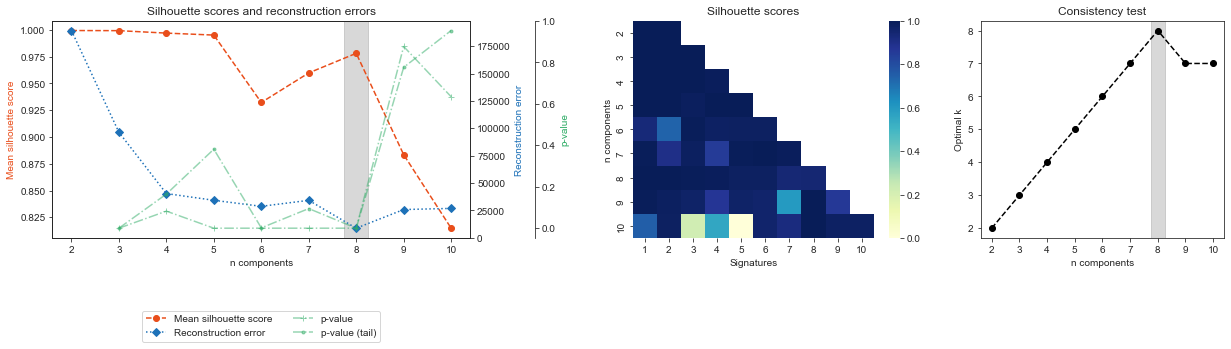

In [4]:
model.plot_selection()

DESCRIBE THE ABOVE PLOT

## Matching and refitting

Define a grid for matching and refitting

In [ ]:
model.thresh1_all = np.logspace(-3, -1, 10, endpoint = True)
model.thresh1_match_all = np.logspace(-3, -1, 10, endpoint = True)

Load the catalog that will be used for refitting.
Restrict signatures to the specific tumor type.
Remove MMRD POLE-exo related signatures, if you have previously exclued these samples.

In [ ]:
catalog = musical.load_catalog('COSMIC-MuSiCal_v3p2_SBS_WGS')

You can restrict catalog to the tumor type and based on MMRD POLE status as follows. PPD stands for polymerase proof-reading deficiency

In [3]:
catalog.restrict_catalog(tumor_type = 'Breast.AdenoCA', is_MMRD = False, is_PPD = False)

NameError: name 'catalog' is not defined

Get the signature matrix and signature names

In [ ]:
W_catalog = np.array(catalog.W)
signatures = np.array(catalog.signatures)

Run refitting

In [ ]:
model.run_reassign(W_catalog = W_catalog, signatures = signatures)

Plot signatures that were discovered

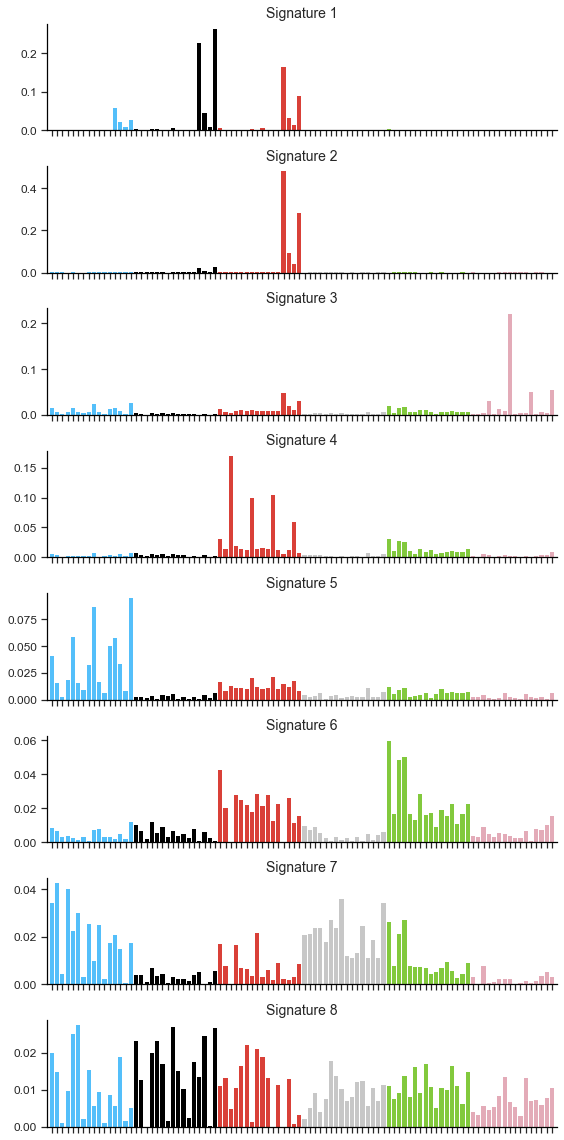

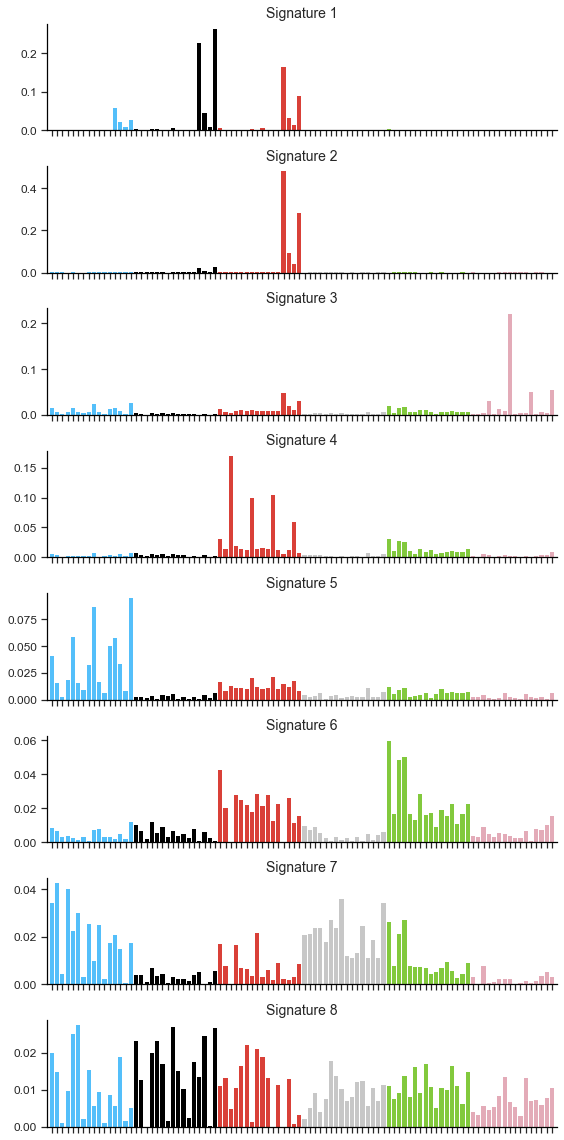

In [7]:
musical.sigplot_bar(model.W)

## Validation

Run validation with a single command line (we suggest to perform this on a computing cluster because grid x 3 de novo discoveries are performed

In [ ]:
model.validate_assignment()

The above step is resource intensive so you can load the result saved in the data folder

In [ ]:
with open('data/simulated/musical_output_simul_8sig_validate.pkl', 'rb') as f:
    model = pickle.load(f)

The best refitting and matching parameters are selected based on the distance between signatures in simulations and data

In [ ]:
print(model.thresh1)
print(model.thresh1_match)

Plot signatures discovered in data

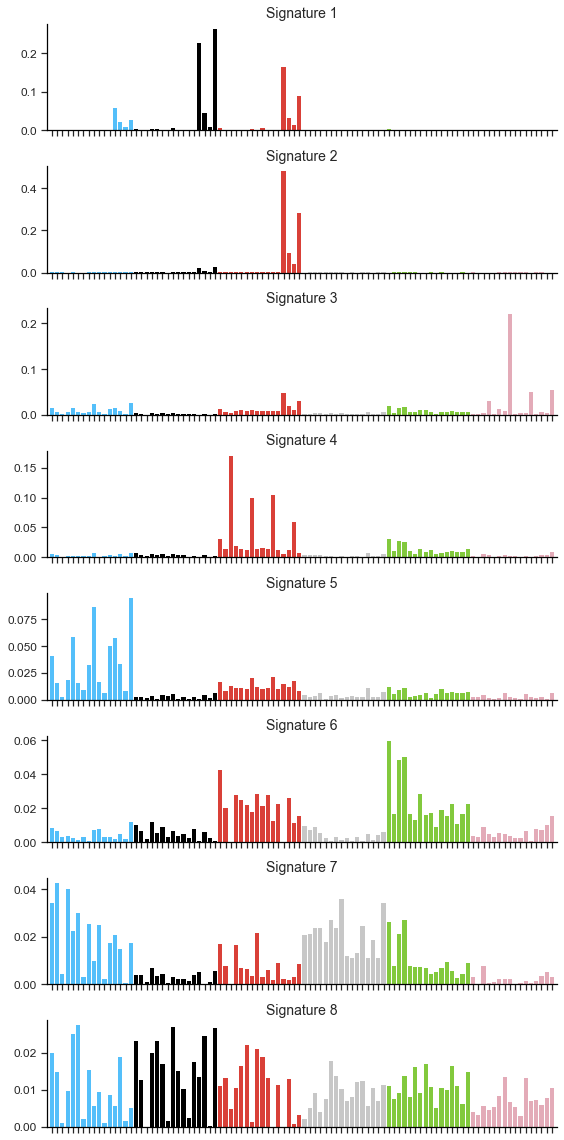

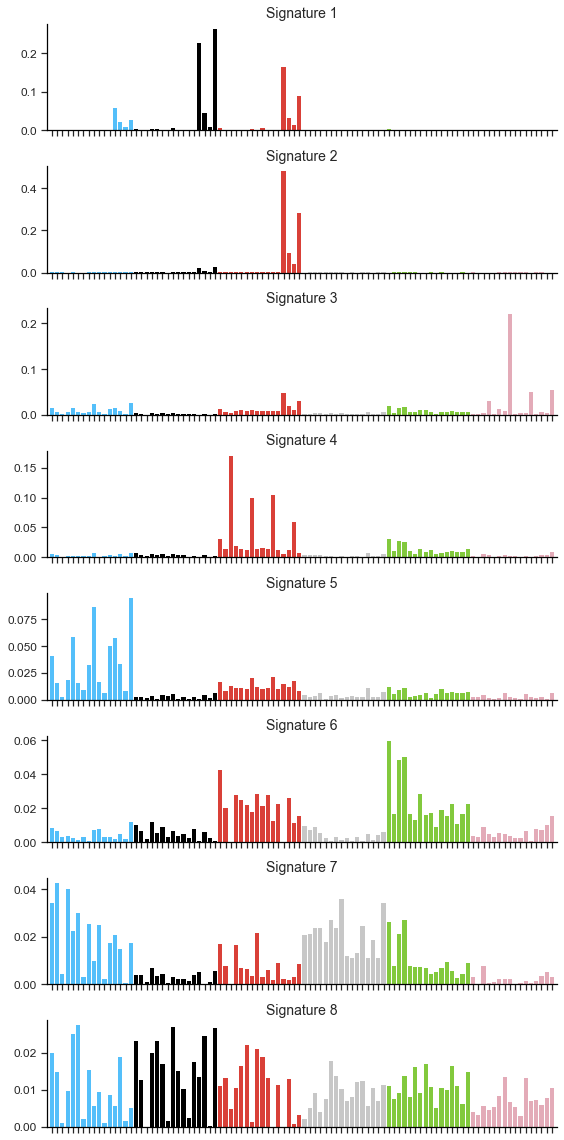

In [8]:
musical.sigplot_bar(model.W)

Plot signatures discovered in simulated data. The de novo signatures for other grid parameters are saved in model.W_simul_all

In [ ]:
musical.sigplot_bar(model.W_simul)

You can save the assignments as data tables:

In [ ]:
W_s = model.W_s
H_s = model.H_s
df_W_s = pd.DataFrame(W_s, columns=signatures, index=model.features)
df_H_s = pd.DataFrame(t(H_s), columns=signatures, index=samples)
df_W_s.to_csv('W_s_example.csv')
df_H_s.to_csv('H_s_example.csv')

#### Alternative solution using distance between simulation and data with the largest discrepency

The best grid parameter is selected based on total cosine distance between W and W_simul, minimum number of signatures and smallest frobennius error in comparison of H and H_simul. It is also possible to use the cosine distance between W and W_simul for the signature with the largest discrepency. The grid index for this solution can be found and used to access the results

In [ ]:
print(model.best_grid_index)
print(model.thresh1_all[model.best_grid_index])
print(model.thresh1_match[model.best_grid_index])

The signature assignments for all grid indices are saved in model.W_s_all and model.H_s_all. You can get the assignments corresponding to the above index:

In [ ]:
W_s_alternative = model.W_s_all[model.best_grid_index]
H_s_alternative = model.H_s_all[model.best_grid_index]

## Comparing solution to the true exposures that were used to generate the input X matrix 

Download the input exposures and signatures

In [ ]:
H_truth = pd.read_csv('data/simulated/H_s_simul_8sig.csv')
W_truth = pd.read_csv('data/simulated/W_s_simul_8sig.csv')
signatures_truth = np.array(W_truth.columns)
H_truth = np.array(H_truth)
W_truth = np.array(W_truth)

Calculate sensitivity, false positive rate

In [ ]:
inds = [index for index,item in enumerate(signatures_assigned) if item in signatures_truth]
inds_truth = [index for index,item in enumerate(signatures_truth) if item in signatures_assigned[inds]]

inds_unmatched = [index for index,item in enumerate(signatures_assigned) if item not in signatures_truth]
inds_truth_unmatched = [index for index,item in enumerate(signatures_truth) if item not in signatures_assigned]

per_sample_agreement = (H_s[inds,:] > 0) == (H_truth[inds_truth,:] > 0)

In [ ]:
accuracy = np.sum(per_sample_agreement)/np.size(H_truth)

In [ ]:
sensitivity = np.sum((H_truth[inds_truth] > 0) * per_sample_agreement)/np.sum(H_truth > 0) 
sensitivity = sensitivity - np.sum(H_truth[inds_truth_unmatched,:] > 0)/np.sum(H_truth > 0)

In [ ]:
fpr = 1 - np.sum((H_truth == 0) * per_sample_agreement)/np.sum(H_truth == 0)
fpr = fpr + np.sum(H_s[inds_unmatched] > 0)/np.sum(H_truth == 0)